<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

# **Group 7** - *Modern Data Architectures for Big Data*

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 

In [1]:
import findspark
findspark.init()

Pandas setup to display contents in a better way:

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession
It's a good practice to give the Spark job a name and, before doing the actual data analysis, check the Spark version you're running to be sure that all the functions you'll use will be available and will behave as you expect.

In [3]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
                    .appName("Transport for London - Bus station arrivals analysis")\
                    .getOrCreate()

print(f"This cluster relies on Spark '{spark.version}'")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


This cluster relies on Spark '3.2.1'


<a id='2'></a>
## 2. Lab

In [4]:
from pyspark.sql.functions import input_file_name

# DataFrame creation
BusStationsInfoRawDF = spark.read.json("hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/*/*/*")

# DataFrame updated with an additional column containing the filename contributing to the data in every row.
BusStationsInfoRawDF = BusStationsInfoRawDF.withColumn("filename_path", input_file_name())

# The inferred schema can be visualized using the printSchema() method - definitely semi-structured data.
BusStationsInfoRawDF.printSchema()

root
 |-- $type: string (nullable = true)
 |-- bearing: string (nullable = true)
 |-- currentLocation: string (nullable = true)
 |-- destinationName: string (nullable = true)
 |-- destinationNaptanId: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- expectedArrival: string (nullable = true)
 |-- id: string (nullable = true)
 |-- lineId: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- modeName: string (nullable = true)
 |-- naptanId: string (nullable = true)
 |-- operationType: long (nullable = true)
 |-- platformName: string (nullable = true)
 |-- stationName: string (nullable = true)
 |-- timeToLive: string (nullable = true)
 |-- timeToStation: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timing: struct (nullable = true)
 |    |-- $type: string (nullable = true)
 |    |-- countdownServerAdjustment: string (nullable = true)
 |    |-- insert: string (nullable = true)
 |    |-- read: string (nullable = true)
 |    |-- re

In [5]:
BusStationsInfoRawDF.select("filename_path").printSchema()

root
 |-- filename_path: string (nullable = false)



In [6]:
from  pyspark.sql.functions import col

BusStationsInfoRawDF.select("filename_path")\
                      .distinct()\
                      .orderBy(col("filename_path").desc())\
                      .toPandas()

,filename_path
0,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/12/13/20221212_1316.json
1,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/12/13/20221212_1313.json
2,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/12/13/20221212_1308.json
3,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/12/13/20221212_1307.json
4,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/10/14/20221210_1436.json
5,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/10/14/20221210_1435.json
6,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/10/13/20221210_1316.json
7,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/10/13/20221210_1315.json
8,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/10/13/20221210_1311.json
9,hdfs://localhost:9000/datalake/raw/tfl/bus_stations/2022/12/10/13/20221210_1310.json


<a id='2.3'></a>
### 2.3 Shaping the DataFrame to answer business questions

In [7]:
BusStationsInfoDF = BusStationsInfoRawDF.select("id", "lineName","stationName", "towards","destinationName", 
                                                "direction", "timeToStation", "timestamp","expectedArrival")

BusStationsInfoDF.toPandas().head()

,id,lineName,stationName,towards,destinationName,direction,timeToStation,timestamp,expectedArrival
0,1050007987,142,Priestley Way,Burnt Oak,Watford Junction,inbound,4,2022-12-10T10:42:01.2039082Z,2022-12-10T10:42:05Z
1,-1716900,228,Ashmore Road,"Ladbroke Grove, Kensal Rise Or Harlesden","Park Royal, Central Middlesex Hospital",inbound,9,2022-12-10T10:42:01.2039082Z,2022-12-10T10:42:10Z
2,-1989253748,440,Wembley Stadium Station,"Kingsbury Green, Brent Pk Or Wembley Pk","Wembley, First Way",outbound,31,2022-12-10T10:42:01.2039082Z,2022-12-10T10:42:32Z
3,1503980454,341,Sadler's Wells Theatre,Highbury Or Essex Road,"Meridian Water, Glover Drive Superstore",inbound,1,2022-12-10T10:42:01.2039082Z,2022-12-10T10:42:02Z
4,-327390291,105,Newport Road,"Cranford, Hayes Or West Drayton",Greenford Station,inbound,196,2022-12-10T10:42:01.2039082Z,2022-12-10T10:45:17Z


----------------------------------------------

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

### Average time that it takes to travel from one station to another.

#### **The groupby() method can display columns we select and compute any aggregation fuction we want for the cells. In this case, the mean time spent by a bus going from one station to another is being displayed here**

+--------+--------------------+--------------------+------------------+
|lineName|         stationName|             towards|avg(timeToStation)|
+--------+--------------------+--------------------+------------------+
|      R8|Hail & Ride Beech...|                null|            1793.0|
|     B16|          Upton Road|Sidcup, Welling O...|            1783.0|
|     EL1|         Chapel Road|             Barking|            1777.0|
|     R10| Halstead / the Cock|     Knockholt Pound|            1775.0|
|     355|     Tooting Station|             Mitcham|            1775.0|
|     205|Liverpool Street ...|     Aldgate Or Bank|            1771.0|
|     111|           New Close|Hounslow Or Twick...|            1771.0|
|     302|   Burnt Oak Station|Colindale, Edgwar...|            1770.0|
|     326|           Underhill|Potters Bar Or Ar...|            1765.0|
|     258|         Tyburn Lane|Kenton, Wembley O...|            1764.0|
|     H22|       Treaty Centre| Heston Or Isleworth|            

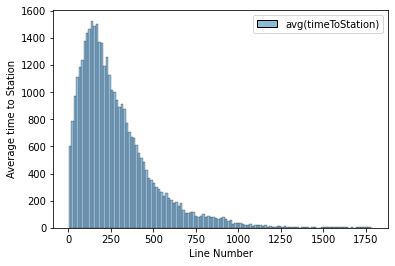

In [9]:
# Grouping the data by Bus line and Station
grouped = BusStationsInfoDF.groupby("lineName", "stationName", "towards")

# Calculate the average time it takes to travel from each station to its destination
avg_times = grouped.avg("timeToStation")
avg_times_pandas = avg_times.toPandas()

# show the results
avg_times.orderBy(col("avg(timeToStation)").desc()).show()


sns.histplot(avg_times_pandas)
plt.xlabel("Line Number")
plt.ylabel("Average time to Station")
plt.show()

### Spark + SQL to display the busiest bus routes and stations.

#### **Spark has built-in compatibility with SQL, which means that we completely can execute SQL queries in Spark and store the result inside of a dataframe.**

+--------+---------+
|lineName|num_buses|
+--------+---------+
|      64|     1395|
|     463|     1353|
|     465|     1282|
|     314|     1167|
|     492|     1150|
|      S3|     1144|
|     107|     1136|
|     221|     1114|
|      20|     1090|
|     216|     1089|
|     290|     1081|
|      65|     1071|
|     370|     1068|
|     192|     1064|
|      51|     1055|
|     174|     1050|
|     145|     1044|
|      99|     1031|
|     352|     1029|
|     191|     1025|
+--------+---------+
only showing top 20 rows



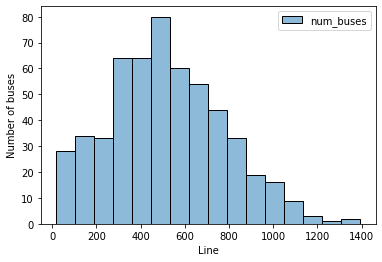

In [10]:
# We created the dataframe as a temporary view, to use it in the SQL statement
BusStationsInfoDF.createOrReplaceTempView("bus_data")

# Finding the busiest bus routes
busiest_routes = spark.sql("""
  SELECT lineName, COUNT(*) AS num_buses
  FROM bus_data
  GROUP BY lineName
  ORDER BY num_buses DESC
""")
busiest_routes.show()


busiest_routes_pandas = busiest_routes.toPandas()
sns.histplot(busiest_routes_pandas)
plt.xlabel("Line")
plt.ylabel("Number of buses")
plt.show()

In [11]:
# Find the busiest bus stations
busiest_stations = spark.sql("""
  SELECT stationName, COUNT(*) AS num_buses
  FROM bus_data
  GROUP BY stationName
  ORDER BY num_buses DESC
""")

busiest_stations.show()

print("Hail & Ride Section is a specific bus route with a different behaviour. We are going to drop it from the dataframe since it is not a normal station")

busiest_stations2 = busiest_stations.where("stationName not like('Hail & Ride Section%')")
busiest_stations2.show()

+--------------------+---------+
|         stationName|num_buses|
+--------------------+---------+
| Hail & Ride Section|     1469|
|           Park Road|      447|
|         Church Road|      337|
|          The Avenue|      294|
|            New Road|      249|
|         Park Avenue|      244|
|         Forest Road|      234|
|       Victoria Road|      225|
|Hail & Ride Secti...|      221|
|   Beaconsfield Road|      220|
|           Long Lane|      214|
|       Windmill Road|      212|
|Hail & Ride Secti...|      212|
|          Green Lane|      206|
|         The Fairway|      204|
|      St Mary's Road|      196|
| North Circular Road|      192|
|      Granville Road|      189|
|           The Green|      186|
|    Nightingale Road|      183|
+--------------------+---------+
only showing top 20 rows

Hail & Ride Section is a specific bus route with a different behaviour. We are going to drop it from the dataframe since it is not a normal station


+--------------------+---------+
|         stationName|num_buses|
+--------------------+---------+
|           Park Road|      447|
|         Church Road|      337|
|          The Avenue|      294|
|            New Road|      249|
|         Park Avenue|      244|
|         Forest Road|      234|
|       Victoria Road|      225|
|   Beaconsfield Road|      220|
|           Long Lane|      214|
|       Windmill Road|      212|
|          Green Lane|      206|
|         The Fairway|      204|
|      St Mary's Road|      196|
| North Circular Road|      192|
|      Granville Road|      189|
|           The Green|      186|
|    Nightingale Road|      183|
|        Spencer Road|      176|
|Golders Green Sta...|      174|
|        Station Road|      171|
+--------------------+---------+
only showing top 20 rows



In [12]:
busiest_stations_pandas = busiest_stations2.toPandas()

bin_labels = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-100", "100+"]
bins = [0, 10, 20, 30, 40, 50, 100, float("inf")]

# Use the pd.cut() function to bin the data into the specified intervals
busiest_stations_pandas["binned"] = pd.cut(busiest_stations_pandas["num_buses"], bins=bins, labels=bin_labels)


busiest_stations_pandas.head()

,stationName,num_buses,binned
0,Park Road,447,100+
1,Church Road,337,100+
2,The Avenue,294,100+
3,New Road,249,100+
4,Park Avenue,244,100+


11-20     3326
31-40     2977
21-30     1975
51-100     583
0-10       542
41-50      451
100+        91
Name: binned, dtype: int64

<AxesSubplot:>

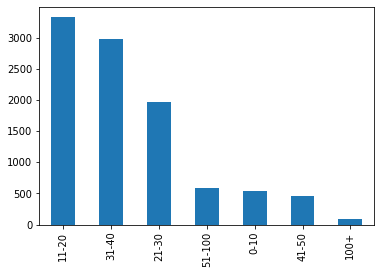

In [13]:
bins = busiest_stations_pandas["binned"]

bins = bins.value_counts()
display(bins)
bins.plot(kind='bar')

### Most common destinations

#### Here, we have grouped all the bus lines and destinations, and calculated all of the different buses which are running that line to x Destination. That way, we obtain the number of buses which are in every different line and go to every destination

In [14]:
most_common_destinations = BusStationsInfoDF.groupby("lineName","destinationName").count()
most_common_destinations_ordered = most_common_destinations.orderBy(col("count").desc())


most_common_destinations_ordered.show()

+--------+-------------------+-----+
|lineName|    destinationName|count|
+--------+-------------------+-----+
|      64|      New Addington|  706|
|      64|Thornton Heath Pond|  689|
|     463|      Pollards Hill|  684|
|     463|     Coulsdon South|  669|
|     465|            Dorking|  657|
|     465|           Kingston|  625|
|     492|          Bluewater|  623|
|     314|     Eltham Station|  592|
|      S3|            Belmont|  589|
|     314|      New Addington|  575|
|     216|            Staines|  569|
|     352|      Bromley North|  565|
|     221|    Edgware Station|  565|
|     290|            Staines|  563|
|      20|             Debden|  561|
|     H28|      Bull's Bridge|  555|
|      S3|       Malden Manor|  555|
|     107|         New Barnet|  553|
|     192|     Tottenham Hale|  552|
|     370|           Lakeside|  552|
+--------+-------------------+-----+
only showing top 20 rows

